# Step 1 - Prepare network data
## Project: Growing Urban Bicycle Networks

This notebook downloads bicycle and street network data sets and prepares them for analysis.

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-06-09  
Last modified: 2021-03-10

## Preliminaries

### Parameters

In [2]:
debug = True # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



### Setup

In [3]:
%run -i path.py
#%run -i setup.py
%run -i setupCPH.py

%load_ext watermark
%watermark -n -v -m -g -iv
import statistics

Loaded PATH.

Setup finished.

Python implementation: CPython
Python version       : 3.8.2
IPython version      : 8.5.0

Compiler    : Clang 9.0.1 
OS          : Darwin
Release     : 18.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: b795eaefba9eb6349c319ca07997ebd31e033f57

pandas    : 1.4.4
geopandas : 0.11.1
watermark : 2.3.1
numpy     : 1.23.3
matplotlib: 3.6.0
fiona     : 1.8.21
igraph    : 0.9.1
csv       : 1.0
geojson   : 2.5.0
pyproj    : 3.4.0
shapely   : 1.8.4
osmnx     : 0.16.2
sys       : 3.8.2 | packaged by conda-forge | (default, Apr 24 2020, 07:56:27) 
[Clang 9.0.1 ]
networkx  : 2.8.6
osgeo     : 3.2.1



### Functions

In [4]:
%run -i functions.py

Loaded functions.



## Load bike traffic data


In [242]:
#Load bike data
count_df = pd.read_csv("../../bikenwgrowth_external/data/copenhagen/bikedata/bicycle_counts.csv")
count_df = count_df[count_df.year ==2019]
bikelanes = gpd.GeoDataFrame(count_df, geometry=gpd.points_from_xy(count_df['long'], count_df['lat']))

In [283]:
pop_den_df = pd.read_csv("../../bikenwgrowth_external/data/copenhagen/bikedata/dnk_pd_2019_1km_ASCII_XYZ.csv")
#pop_den_df = pd.read_csv("../../bikenwgrowth_external/data/copenhagen/bikedata/dnk_pd_2019_1km_ASCII_XYZ_small.csv")


In [244]:
#convert to fraction. All bikecounts are added 1 to avoid division by zero (if zero bikes).
count_df['bcount_attr']= count_df['bicycle_count']
for i in range(len(count_df)):
    count_df['bcount_attr'].iloc[i] = 1.0/float(count_df['bicycle_count'].iloc[i]+1)

/var/folders/r8/tq2ln28d2vg5b08rjdywrcvc0000gn/T/ipykernel_30453/1834362966.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df['bcount_attr'].iloc[i] = 1.0/float(count_df['bicycle_count'].iloc[i]+1)


In [245]:
#Normalise bikecounts in range 0.1 to 1 to avoid zero values
x = count_df.drop(count_df.columns[[0,1,2,3,4,5,6]], axis=1) #returns a numpy array of only bikecounts
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1.0))
x_scaled = min_max_scaler.fit_transform(x)
bike_norm_df = pd.DataFrame(x_scaled)

In [246]:
#update count_df with normalised values

for i in range(len(count_df)):
    count_df['bcount_attr'].iloc[i] = bike_norm_df.iloc[i]

In [247]:
bikelanes = gpd.GeoDataFrame(count_df, geometry=gpd.points_from_xy(count_df['long'], count_df['lat']))

In [248]:
count_df

bicycle_count      date  year  \
3            42600  20190912  2019   
4            10000  20190904  2019   
5             4200  20190613  2019   
6             2200  20190507  2019   
9            21000  20190912  2019   
..             ...       ...   ...   
577            100  20190828  2019   
578            700  20190618  2019   
579            400  20190828  2019   
580            400  20190618  2019   
581           1300  20190618  2019   

                                       coordinates       long        lat  \
3     POINT (12.563784830098982 55.68673054140091)  12.563785  55.686731   
4     POINT (12.557917540101617 55.67797681383055)  12.557918  55.677977   
5     POINT (12.510990440718215 55.65050283197625)  12.510990  55.650503   
6     POINT (12.599845636263538 55.63848509063259)  12.599846  55.638485   
9    POINT (12.566369474794929 55.685708418286154)  12.566369  55.685708   
..                                             ...        ...        ...   
577    POINT (12.530960063914618 55.6458971323602)  12.530960  55.645897   
578   POINT (12.503275444518247 55.64937903079855)  12.503275  55.649379   
579   POINT (12.529619140351253 55.64710829706531)  12.529619  55.647108   
580    POINT (12.487710078615091 55.6523309305399)  12.487710  55.652331   
581    POINT (12.49022298916054 55.64911673386253)  12.490223  55.649117   

                      geometry  bcount_attr  
3    POINT (12.56378 55.68673)     0.100000  
4    POINT (12.55792 55.67798)     0.106972  
5    POINT (12.51099 55.65050)     0.119550  
6    POINT (12.59985 55.63849)     0.139259  
9    POINT (12.56637 55.68571)     0.102200  
..                         ...          ...  
577  POINT (12.53096 55.64590)     1.000000  
578  POINT (12.50328 55.64938)     0.227841  
579  POINT (12.52962 55.64711)     0.325083  
580  POINT (12.48771 55.65233)     0.325083  
581  POINT (12.49022 55.64912)     0.167897  

[123 rows x 8 columns]

In [284]:
#convert to fraction. All pop densities are added 1 to avoid division by zero (if zero density).
pop_den_df['pop_den_attr']= pop_den_df['Z']
for i in range(len(pop_den_df['Z'])):
    pop_den_df['pop_den_attr'].iloc[i] = 1.0/float(pop_den_df['pop_den_attr'].iloc[i]+1)

In [285]:
#Normalise population density
x = pop_den_df.drop(pop_den_df.columns[[0,1,2]], axis=1) #returns a numpy array of only bikecounts
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1.0))
x_scaled = min_max_scaler.fit_transform(x)
pop_den_norm_df = pd.DataFrame(x_scaled)

In [286]:
for i in range(len(pop_den_df)):
    pop_den_df['pop_den_attr'].iloc[i] = pop_den_norm_df.iloc[i]

In [287]:
pop_den_df.rename(columns = {'X':'long', 'Y':'lat','Z':'pop_den'}, inplace = True)

In [288]:
pop_den_df

long        lat    pop_den  pop_den_attr
0      10.586250  57.753750   6.613836      0.223133
1      10.594583  57.753750   6.336119      0.227795
2      10.602917  57.753750   6.854702      0.219356
3      10.611250  57.753750   7.362468      0.212107
4      10.619583  57.753750   6.530416      0.224497
...          ...        ...        ...           ...
94672  11.944583  54.562083  31.489664      0.128835
94673  11.952917  54.562083  29.369946      0.130850
94674  11.961250  54.562083   6.047539      0.233029
94675  11.969583  54.562083   8.983855      0.193896
94676  11.977917  54.562083  13.239523      0.165826

[94677 rows x 4 columns]

402.6111145019531


## Download and wrangle data

### Networks

In [233]:
for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
        if debug: # Draw location polygons and their holes
            try:
                color = cm.rainbow(np.linspace(0,1,len(location)))
                for poly,c in zip(location, color):
                    plt.plot(*poly.exterior.xy, c = c)
                    for intr in poly.interiors:
                        plt.plot(*intr.xy, c = "red")
            except:
                plt.plot(*location.exterior.xy)
            plt.show()
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        location = shapely.geometry.shape(first['geometry'])
    
    Gs = {}
    for parameterid, parameterinfo in tqdm(osmnxparameters.items(), desc = "Networks", leave = False):
        for i in range(0,10): # retry
            try:
                Gs[parameterid] = ox.graph_from_polygon(location, 
                                       network_type = parameterinfo['network_type'],
                                       custom_filter = (parameterinfo['custom_filter']),
                                       retain_all = parameterinfo['retain_all'],
                                       simplify = False)
            except ValueError:
                Gs[parameterid] = nx.empty_graph(create_using = nx.MultiDiGraph)
                print(placeid + ": No OSM data for graph " + parameterid + ". Created empty graph.")
                break
            except ConnectionError or UnboundLocalError:
                print("ConnectionError or UnboundLocalError. Retrying.")
                continue
            except:
                print("Other error. Retrying.")
                continue
            break
        if parameterinfo['export']: ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)

    # Compose special cases biketrack, bikeable, biketrackcarall
    parameterid = 'biketrack'
    Gs[parameterid] = nx.compose_all([Gs['bike_cyclewaylefttrack'], Gs['bike_cyclewaytrack'], Gs['bike_highwaycycleway'], Gs['bike_bicycleroad'], Gs['bike_cyclewayrighttrack'], Gs['bike_designatedpath'], Gs['bike_cyclestreet']])
    ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)
    
    parameterid = 'bikeable'
    Gs[parameterid] = nx.compose_all([Gs['biketrack'], Gs['car30'], Gs['bike_livingstreet']]) 
    ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)
    
    parameterid = 'biketrackcarall'
    Gs[parameterid] = nx.compose(Gs['biketrack'], Gs['carall']) # Order is important
    ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)
    
    print([k for k in Gs ])
    
    for parameterid in networktypes[:-2]:
        #G_temp = nx.MultiDiGraph(ox.utils_graph.get_digraph(ox.simplify_graph(Gs[parameterid]))) # This doesnt work - cant get rid of multiedges
        ox_to_csv(ox.simplify_graph(Gs[parameterid]), PATH["data"] + placeid + "/", placeid, parameterid, "_simplified")

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

Networks:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


copenhagen: Successfully wrote graph car30


/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


copenhagen: Successfully wrote graph carall


/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:281: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/osmnx/utils_geo.py:375: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/si

copenhagen: Successfully wrote graph biketrack
copenhagen: Successfully wrote graph bikeable
copenhagen: Successfully wrote graph biketrackcarall
['car30', 'carall', 'bike_cyclewaytrack', 'bike_highwaycycleway', 'bike_designatedpath', 'bike_cyclewayrighttrack', 'bike_cyclewaylefttrack', 'bike_cyclestreet', 'bike_bicycleroad', 'bike_livingstreet', 'biketrack', 'bikeable', 'biketrackcarall']


In [234]:
# Compress all data files (will not do anything if files were compressed already)
for folder, subfolders, files in os.walk(PATH["data"]):
    for file in files:
        if file.endswith('es.csv'):
            compress_file(folder + "/", file.split(".")[0])

In [232]:
#Set the two new attributes for the Gs carall graph for popden and bcount. all edges are initially set as the average edge length multiplied by the max(in other words the min value) of the bcount_attr and the pop_den_attr

max_bcount_attr = max(count_df['bcount_attr'])
max_pop_den_attr = max(pop_den_df['pop_den_attr'])
with open('../../bikenwgrowth_external/data/copenhagen/bikedata/max_bcount_attr.pkl', 'wb') as y:
    pickle.dump(max_bcount_attr, y)
with open('../../bikenwgrowth_external/data/copenhagen/bikedata/max_pop_den_attr.pkl', 'wb') as y:
    pickle.dump(max_pop_den_attr, y)

edges_len_dict = nx.get_edge_attributes(Gs['carall'], 'length')
edges_len_mean = statistics.mean([k for k in edges_len_dict.values()])

nx.set_edge_attributes(Gs['carall'], edges_len_mean*max_bcount_attr, 'bcount_attr')
nx.set_edge_attributes(Gs['carall'], edges_len_mean*max_pop_den_attr, 'pop_den_attr')





In [257]:
pop_val = 54321.54321

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


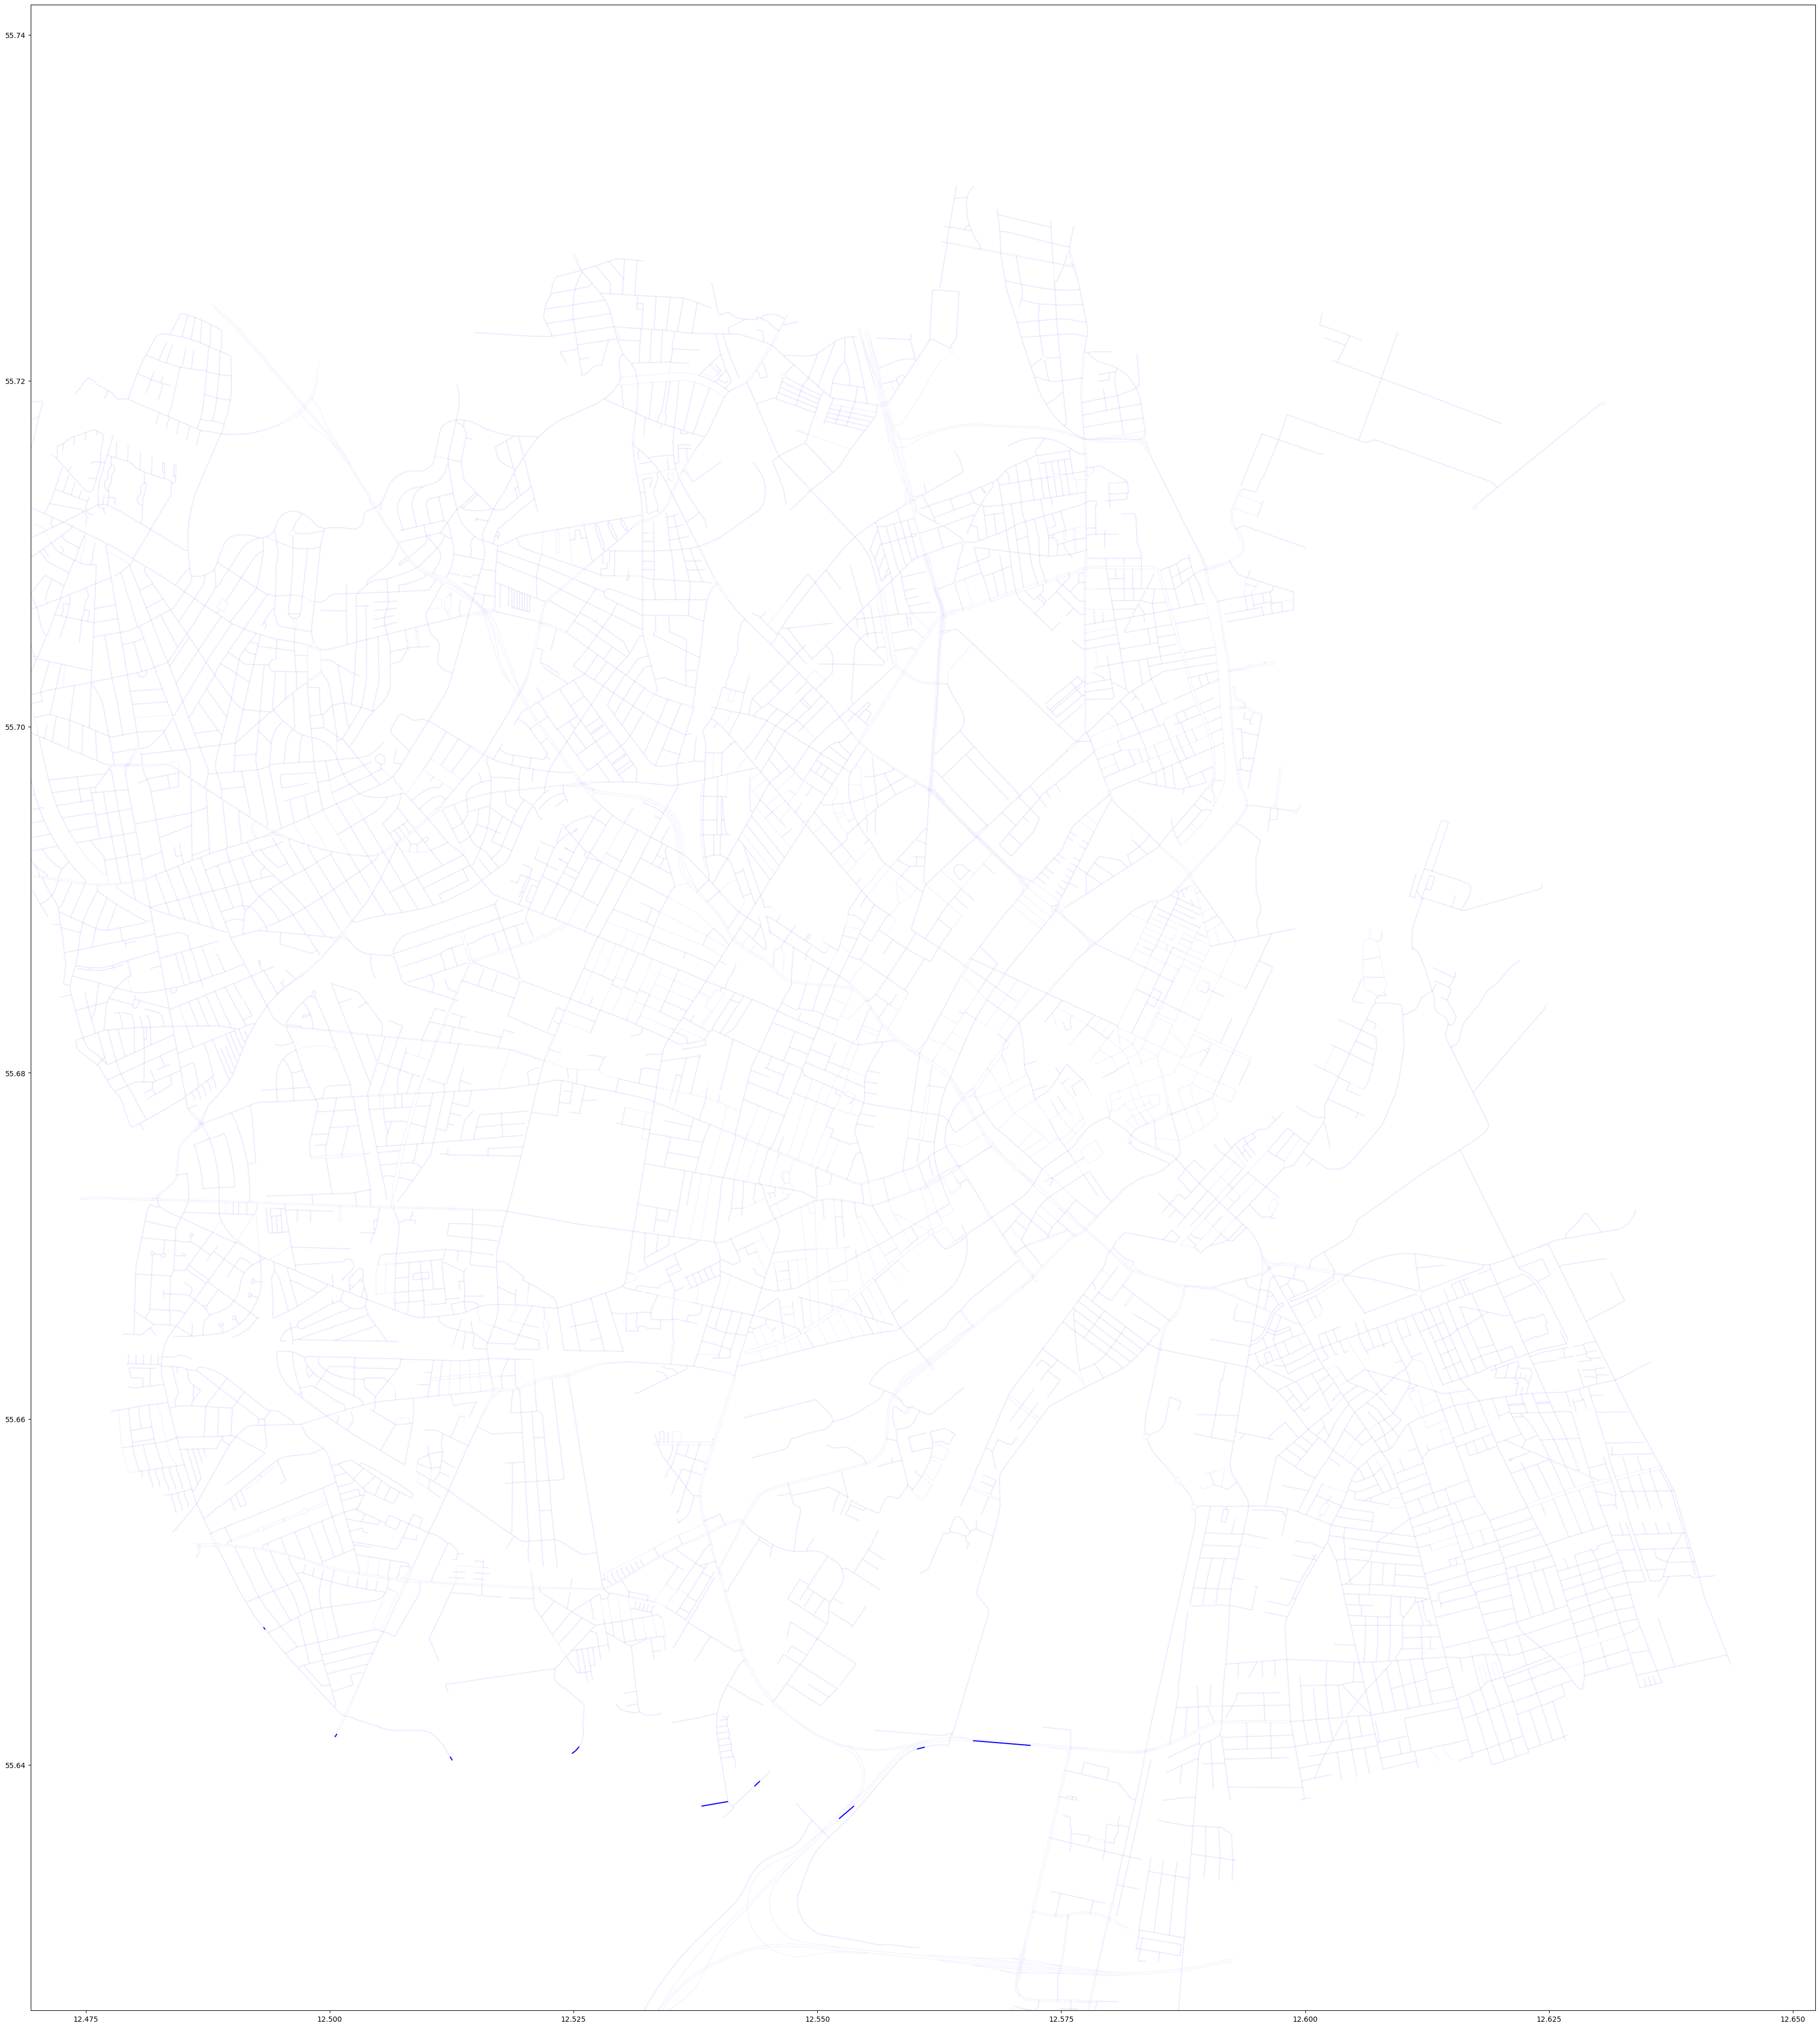

In [281]:
#Without haversine, should have more edges in plot

nx.set_edge_attributes(Gs['carall'], pop_val , 'pop_den_len_attr')
for i in range(len(pop_den_df)):
    ne = ox.distance.get_nearest_edge(Gs['carall'], [pop_den_df.iloc[i].lat,pop_den_df.iloc[i].long])
    pcount = pop_den_df.iloc[i].pop_den_attr
    a,b,c = ne
    edgelength = Gs['carall'].get_edge_data(a,b,c)['length']
    plenatrr = pcount*edgelength
    nx.set_edge_attributes(Gs['carall'], {ne: {"pop_den_len_attr": plenatrr }})

    
# a dictionary of each of the two new attributes in the G_carall graph is generated and saved. 
pop_len_attr_dict = nx.get_edge_attributes(Gs['carall'], "pop_den_len_attr")


lanes = ox.graph_to_gdfs(Gs['carall'], nodes=False) 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ac = [0.04 if (pop_len_attr_dict[k]) == pop_val else 1.0 for k in pop_len_attr_dict]
ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
#bikelanes.plot(ax=ax, color='red')
lanes.plot(ax=ax, color='blue', alpha= ac)
#bikelanes2.plot(ax=ax, color='red', alpha = 0.3,linestyle=(0,(5,10)))
plt.axis([12.469380, 12.652281, 55.625802, 55.741728])
plt.show()

500


/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


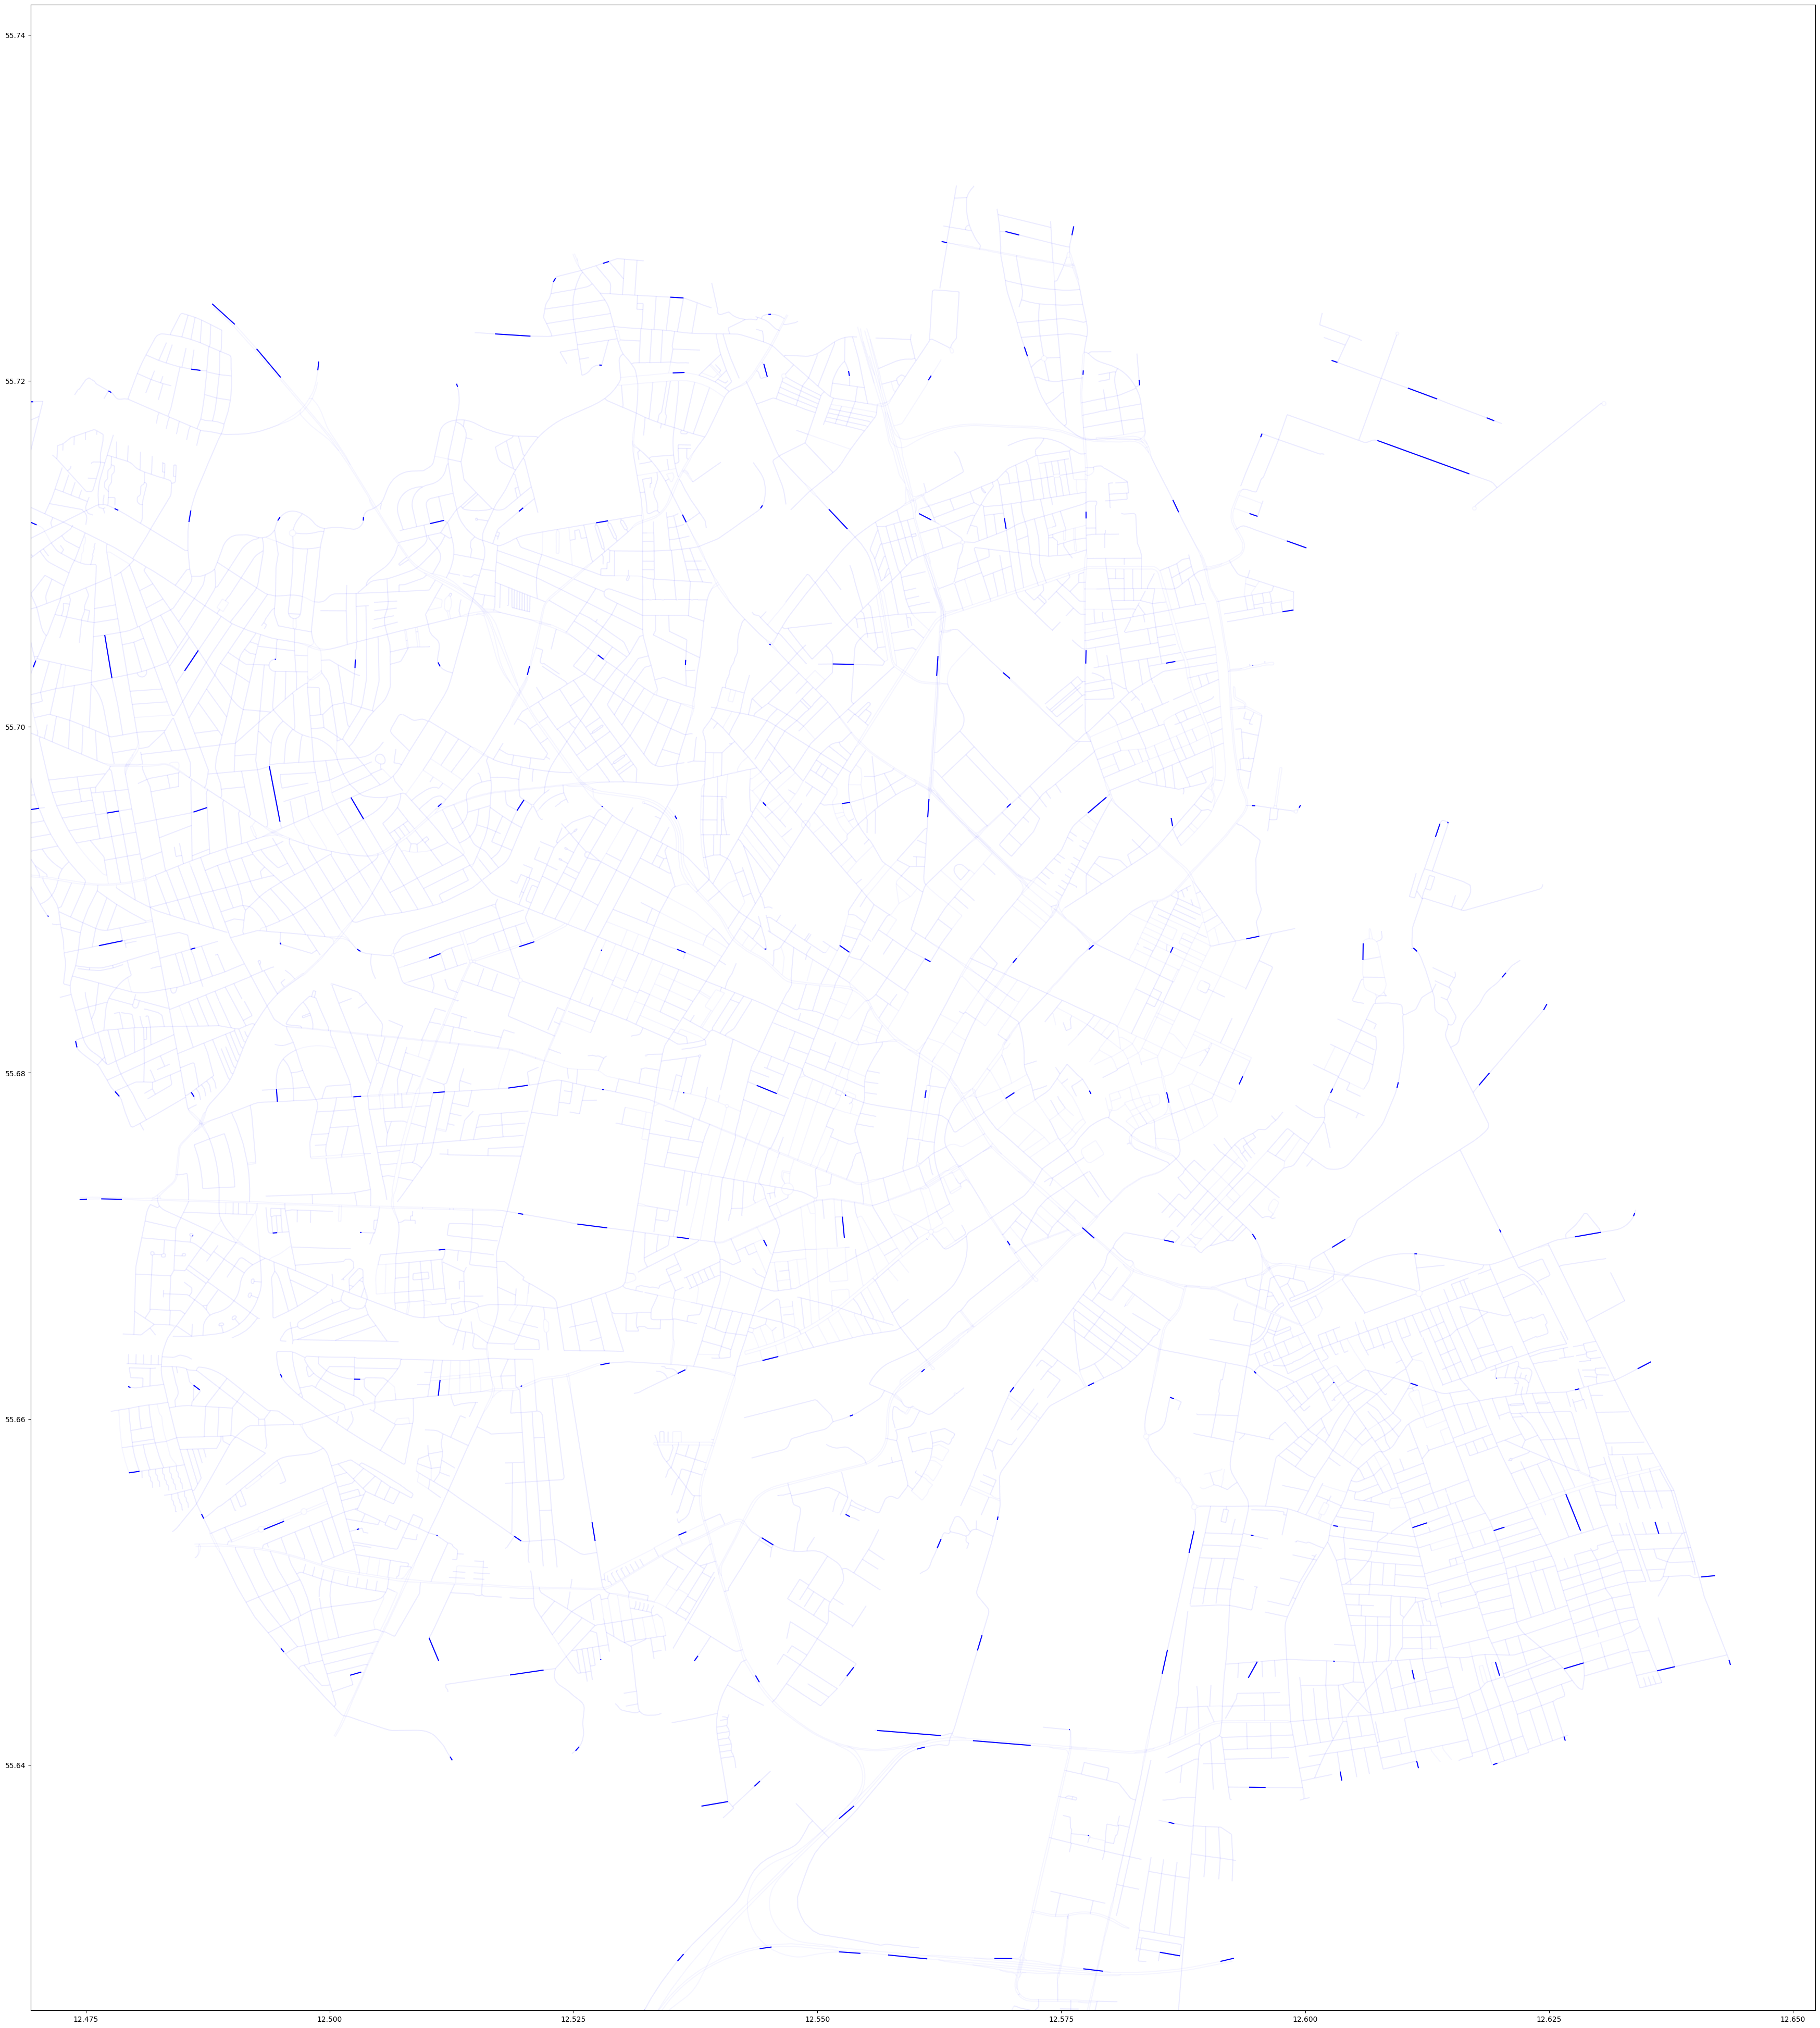

In [289]:
#With haversine, should have less edges in plot
print(snapthreshold)
nx.set_edge_attributes(Gs['carall'], pop_val , 'pop_den_len_attr')
for i in range(len(pop_den_df)):
    coord = 0
    n = ox.distance.get_nearest_node(Gs['carall'], [pop_den_df.iloc[i].lat,pop_den_df.iloc[i].long])
    if haversine([pop_den_df.iloc[i].lat,pop_den_df.iloc[i].long], (Gs['carall'].nodes[n]["y"], Gs['carall'].nodes[n]["x"]), unit="m") <= snapthreshold:
        ne = ox.distance.get_nearest_edge(Gs['carall'], [pop_den_df.iloc[i].lat,pop_den_df.iloc[i].long])
        pcount = pop_den_df.iloc[i].pop_den_attr
        a,b,c = ne
        edgelength = Gs['carall'].get_edge_data(a,b,c)['length']
        plenatrr = pcount*edgelength
        nx.set_edge_attributes(Gs['carall'], {ne: {"pop_den_len_attr": plenatrr }})
    

    
# a dictionary of each of the two new attributes in the G_carall graph is generated and saved. 
pop_len_attr_dict = nx.get_edge_attributes(Gs['carall'], "pop_den_len_attr")

lanes = ox.graph_to_gdfs(Gs['carall'], nodes=False) 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ac = [0.04 if (pop_len_attr_dict[k]) == pop_val else 1.0 for k in pop_len_attr_dict]
ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
#bikelanes.plot(ax=ax, color='red')
lanes.plot(ax=ax, color='blue', alpha= ac)
#bikelanes2.plot(ax=ax, color='red', alpha = 0.3,linestyle=(0,(5,10)))
plt.axis([12.469380, 12.652281, 55.625802, 55.741728])
plt.show()

In [ ]:
for i in range(len(pop_den_df)):
    n = 
    ne = ox.distance.get_nearest_edge(Gs['carall'], [pop_den_df.iloc[i].lat,pop_den_df.iloc[i].long])
    pcount = pop_den_df.iloc[i].pop_den_attr
    a,b,c = ne
    edgelength = Gs['carall'].get_edge_data(a,b,c)['length']
    plenatrr = pcount*edgelength
    nx.set_edge_attributes(Gs['carall'], {ne: {"pop_den_len_attr": plenatrr }})

    
# a dictionary of each of the two new attributes in the G_carall graph is generated and saved. 
pop_len_attr_dict = nx.get_edge_attributes(Gs['carall'], "pop_den_len_attr")
print(pop_len_attr_dict)

### Adding bicycle counts to edges in carall graph

In [8]:
#calculating the mean of bicycle counts and the fraction of this for shortest paths
meancount = statistics.mean(count_df['bicycle_count'])

with open('../../bikenwgrowth_external/data/copenhagen/bikedata/meancount.pkl', 'wb') as y:
    pickle.dump(meancount, y)
    
#calculating the mean of all edge lengths in the graph
edges_len_dict = nx.get_edge_attributes(Gs['carall'], 'length')
edges_len_mean = statistics.mean([k for k in edges_len_dict.values()])

# adding two new attributes to the graph: b_count (the bicycle count which is initially set to the meancountfraction) 
#bc_len_attr: an attribute made to describe a relation between the length on edge and the bicycle count 
#connected to this edge. this value is initially set as the mean of all lengths of paths.
nx.set_edge_attributes(Gs['carall'], meancount, 'b_count')
nx.set_edge_attributes(Gs['carall'], edges_len_mean, 'bc_len_attr')

# The bc_len attribute is updated for all edges in the G_carall graph, 
# and the edge length is multiplied by the fraction of bicycle counts
for e in Gs['carall'].edges():
    a,b=e
    bcount= Gs['carall'].get_edge_data(a,b,0)['b_count']
    bcountfraction = 1.0/float(bcount)
    edgelength = Gs['carall'].get_edge_data(a,b,0)['length']
    bclenatrr = bcountfraction*edgelength
    nx.set_edge_attributes(Gs['carall'], {(a,b,0): {"bc_len_attr": bclenatrr }})


In [9]:
nx.set_edge_attributes(Gs['carall'], 0.0 , 'b_count')

In [10]:
#We iterate through all bikecounters and assign each counter to the nearest edge in the G_carall graph
# For all nearest edges to the bikecounters in the G_carall graph, the bicycle count is updated
# as the fraction of the real value of the nearest bikecounter multiplied by the length of the length of the edge.


for i in range(len(bikelanes)):
    ne = ox.distance.get_nearest_edge(Gs['carall'], [bikelanes.iloc[i].lat,bikelanes.iloc[i].long])
    bcount = bikelanes.iloc[i].bicycle_count
    bcountfraction= 1.0/float(bcount)
    a,b,c = ne
    edgelength = Gs['carall'].get_edge_data(a,b,c)['length']
    bclenatrr = bcountfraction*edgelength
    nx.set_edge_attributes(Gs['carall'], {ne: {"b_count":  bcount ,"bc_len_attr": bclenatrr }})

    
# a dictionary of each of the two new attributes in the G_carall graph is generated and saved. 
edges_lc_dict = nx.get_edge_attributes(Gs['carall'], 'bc_len_attr')
edges_dict = nx.get_edge_attributes(Gs['carall'], 'b_count')
with open('../../bikenwgrowth_external/data/copenhagen/bikedata/edges_dict_no_groups.pkl', 'wb') as f:
    pickle.dump(edges_dict, f)
with open('../../bikenwgrowth_external/data/copenhagen/bikedata/edges_lc_dict_no_groups.pkl', 'wb') as q:
    pickle.dump(edges_lc_dict, q)



In [11]:
ox_to_csv(Gs['carall'], PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall')

copenhagen: Successfully wrote graph carall


In [12]:
ox_to_csv(ox.simplify_graph(Gs['carall']), PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall', "_simplified")

copenhagen: Successfully wrote graph carall_simplified


## applying groups

In [14]:
edges = pd.read_csv("../../bikenwgrowth_external/data/copenhagen/copenhagen_carall_edges.csv")

In [290]:
edges1 = edges[edges.b_count !=0.0]

NameError: name 'edges' is not defined

In [16]:
edges2 = edges1.drop(edges1.columns[[1,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19]], axis=1)

In [17]:
edges3 = edges2.groupby('name')['b_count'].mean().to_frame()

In [18]:
edges3 = edges3.rename(columns={"b_count": "mean_group_b_count"})

In [19]:
result = pd.merge(edges,edges3,on='name',how = 'left')

In [20]:
result.to_csv("../../bikenwgrowth_external/data/copenhagen/copenhagen_carall_edges.csv")

In [21]:
compress_file("../../bikenwgrowth_external/data/copenhagen/","copenhagen_carall_edges")

In [22]:
result2 = result

In [23]:
for i in range(len(result2)):
    num = result2['mean_group_b_count'].iloc[i]
    if num != num:
        result2['mean_group_b_count'].iloc[i]= meancount
    

/var/folders/r8/tq2ln28d2vg5b08rjdywrcvc0000gn/T/ipykernel_8937/1214225813.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result2['mean_group_b_count'].iloc[i]= meancount


In [24]:
#assign the mean_group_b_count to b_count of all edges in graph
i = 0
for e in Gs['carall'].edges():
    a,b=e
    bcount= result2['mean_group_b_count'].iloc[i]
    bcountfraction = 1.0/float(bcount)
    edgelength = Gs['carall'].get_edge_data(a,b,0)['length']
    bclenatrr = bcountfraction*edgelength
    nx.set_edge_attributes(Gs['carall'], {(a,b,0): {"bc_len_attr": bclenatrr, "b_count":bcount }})
    i+=1
#put original b counts back to the assigned edges again.
for i in range(len(bikelanes)):
    ne = ox.distance.get_nearest_edge(Gs['carall'], [bikelanes.iloc[i].lat,bikelanes.iloc[i].long])
    bcount = bikelanes.iloc[i].bicycle_count
    bcountfraction= 1.0/float(bcount)
    a,b,c = ne
    edgelength = Gs['carall'].get_edge_data(a,b,c)['length']
    bclenatrr = bcountfraction*edgelength
    nx.set_edge_attributes(Gs['carall'], {ne: {"b_count":  bcount ,"bc_len_attr": bclenatrr }})

    
# a dictionary of each of the two new attributes in the G_carall graph is generated and saved. 
edges_lc_dict = nx.get_edge_attributes(Gs['carall'], 'bc_len_attr')
edges_dict = nx.get_edge_attributes(Gs['carall'], 'b_count')
with open('../../bikenwgrowth_external/data/copenhagen/bikedata/edges_dict.pkl', 'wb') as f:
    pickle.dump(edges_dict, f)
with open('../../bikenwgrowth_external/data/copenhagen/bikedata/edges_lc_dict.pkl', 'wb') as q:
    pickle.dump(edges_lc_dict, q)
#fp2 = "../../bikenwgrowth_external/data/copenhagen/bikedata/graph_G_carall_graphml.graphml"
ox.save_graphml(Gs['carall'], "../../bikenwgrowth_external/data/copenhagen/bikedata/G_carall_graphml.graphml")

In [25]:
ox_to_csv(Gs['carall'], PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall')

copenhagen: Successfully wrote graph carall


In [26]:
ox_to_csv(ox.simplify_graph(Gs['carall']), PATH["data"] + 'copenhagen' + "/", 'copenhagen', 'carall', "_simplified")

copenhagen: Successfully wrote graph carall_simplified


/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


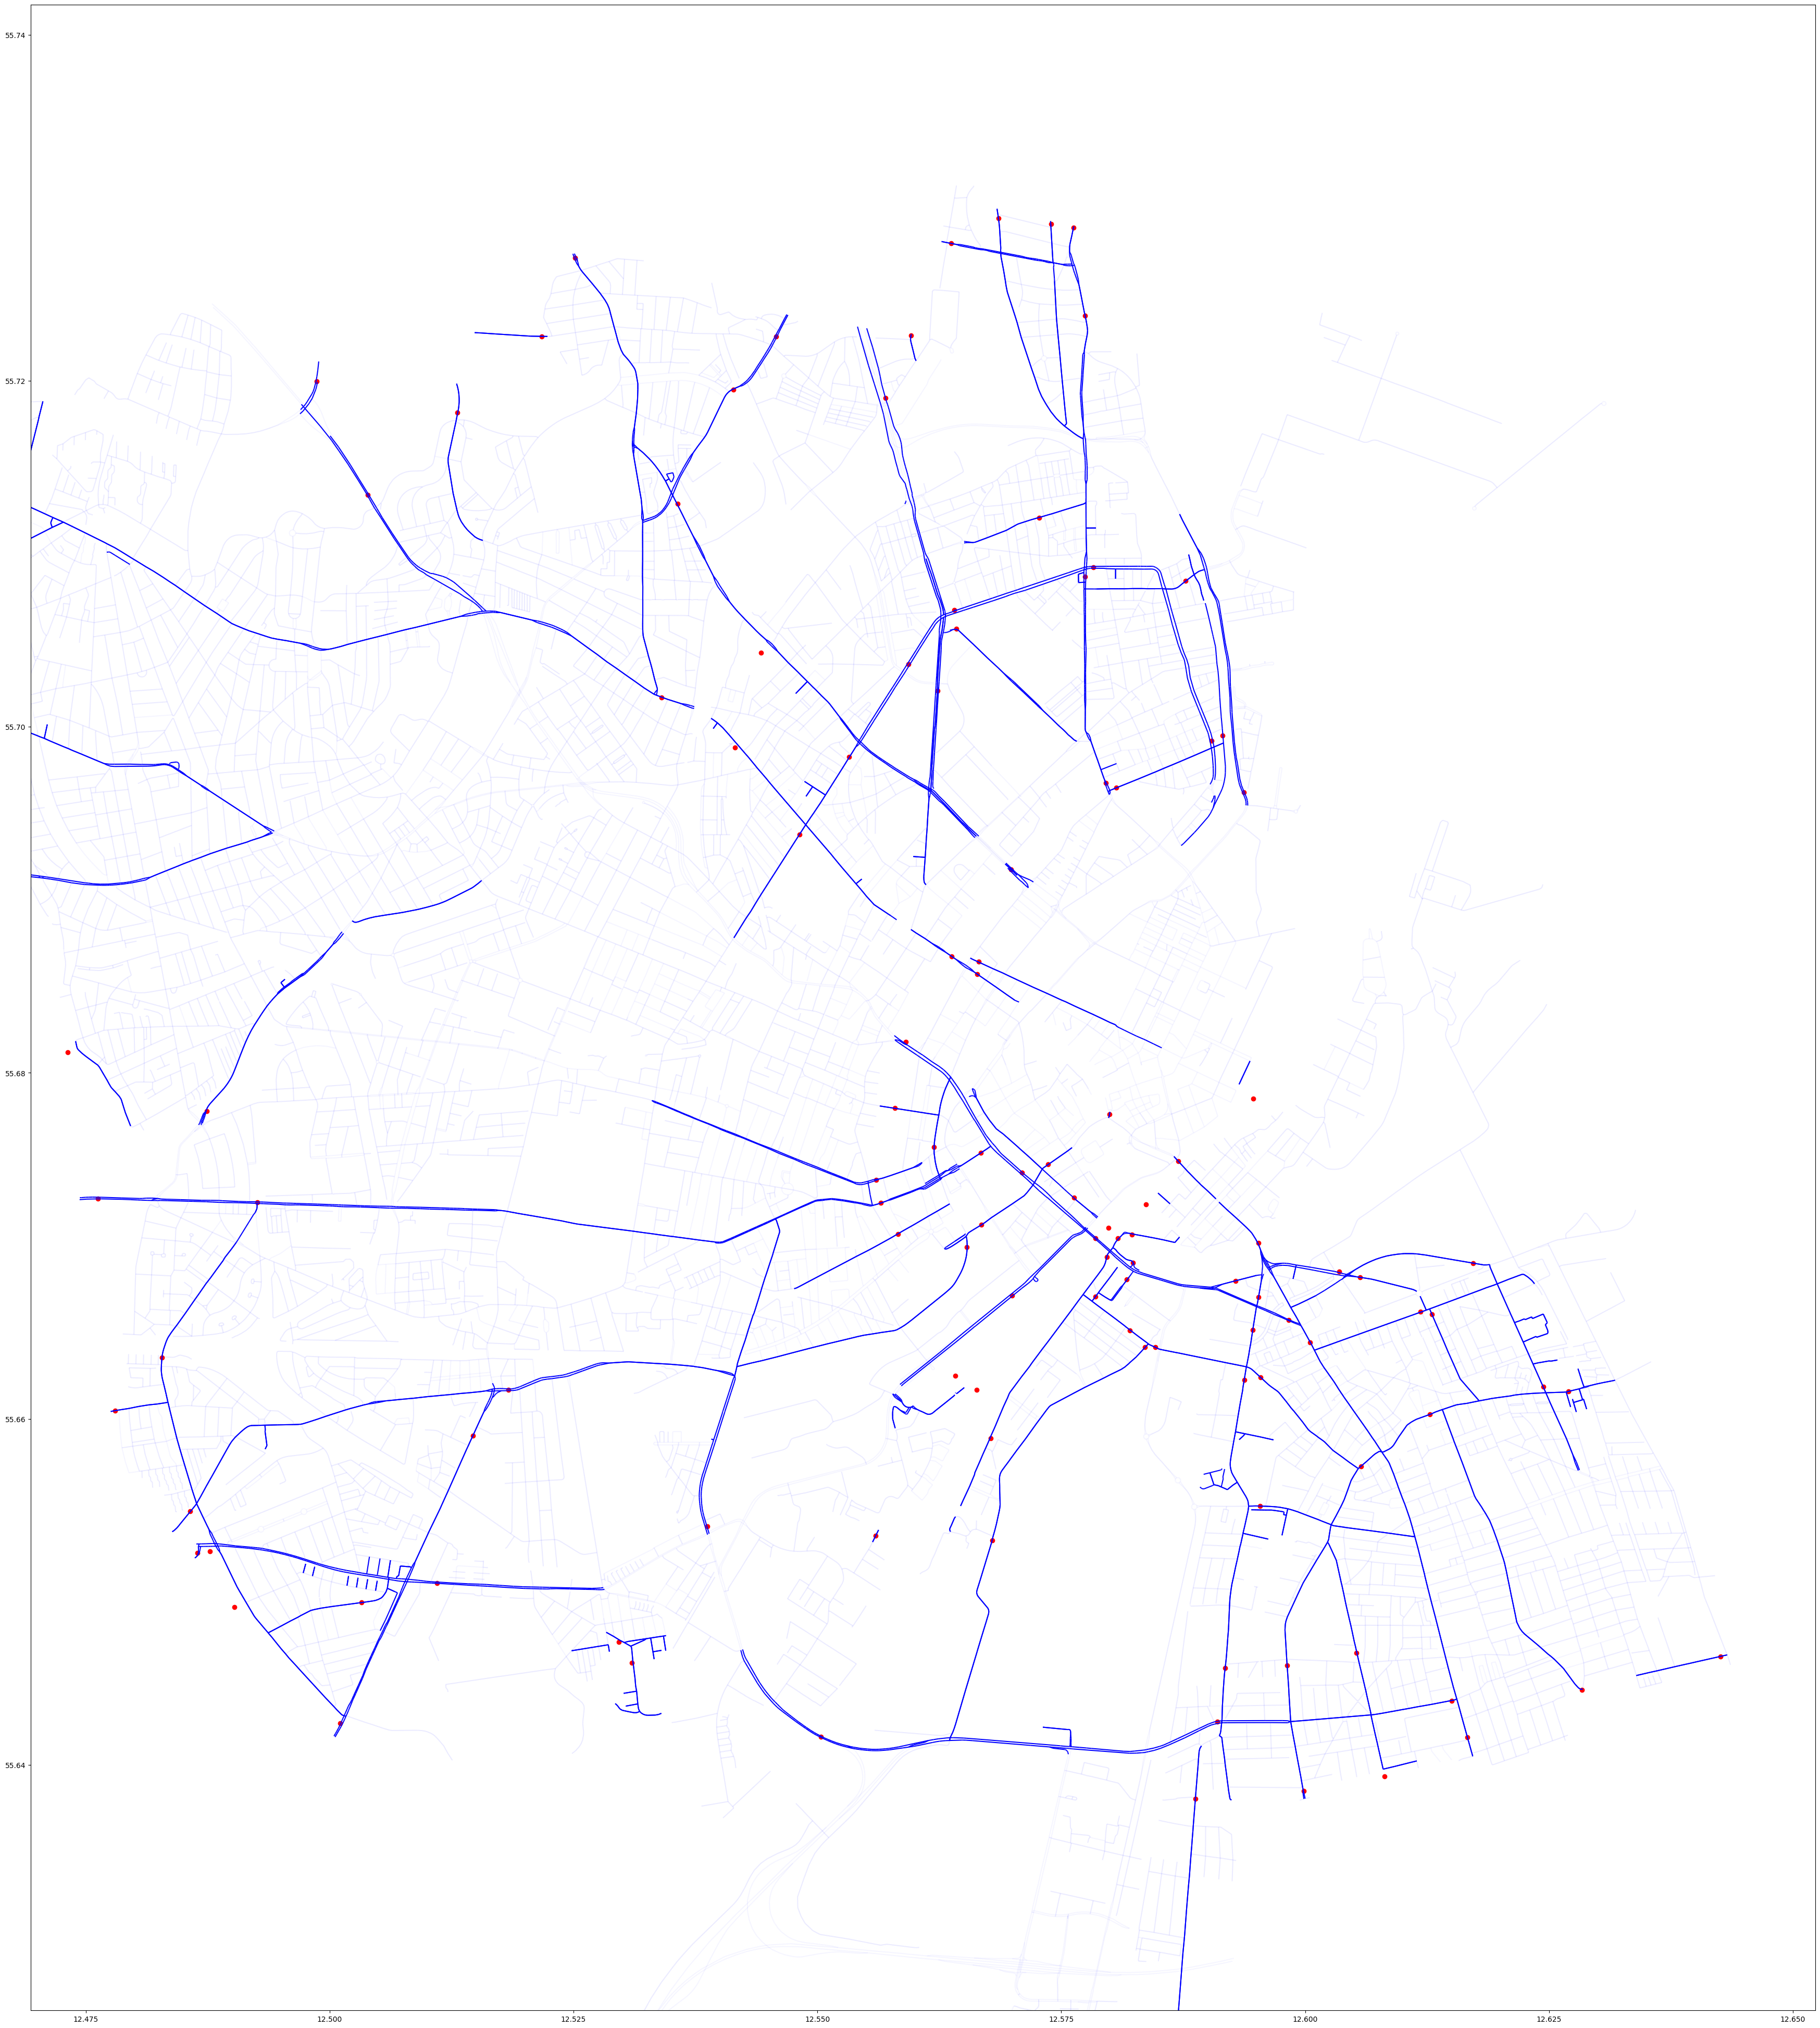

In [27]:
lanes = ox.graph_to_gdfs(Gs['carall'], nodes=False)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ec = ['b' if (edges_dict[k]) ==meancount else 'blue' for k in edges_dict]
ac = [0.04 if (edges_dict[k]) == meancount else 1.0 for k in edges_dict]

ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
bikelanes.plot(ax=ax, color='red')
lanes.plot(ax=ax, color=ec, alpha= ac)
#bikelanes2.plot(ax=ax, color='red', alpha = 0.3,linestyle=(0,(5,10)))



plt.axis([12.469380, 12.652281, 55.625802, 55.741728])


plt.show()

In [28]:
G_carall = ox.load_graphml('../../bikenwgrowth_external/data/copenhagen/bikedata/G_carall_graphml.graphml')

/Users/Kristof/opt/anaconda3/envs/OSMNX/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


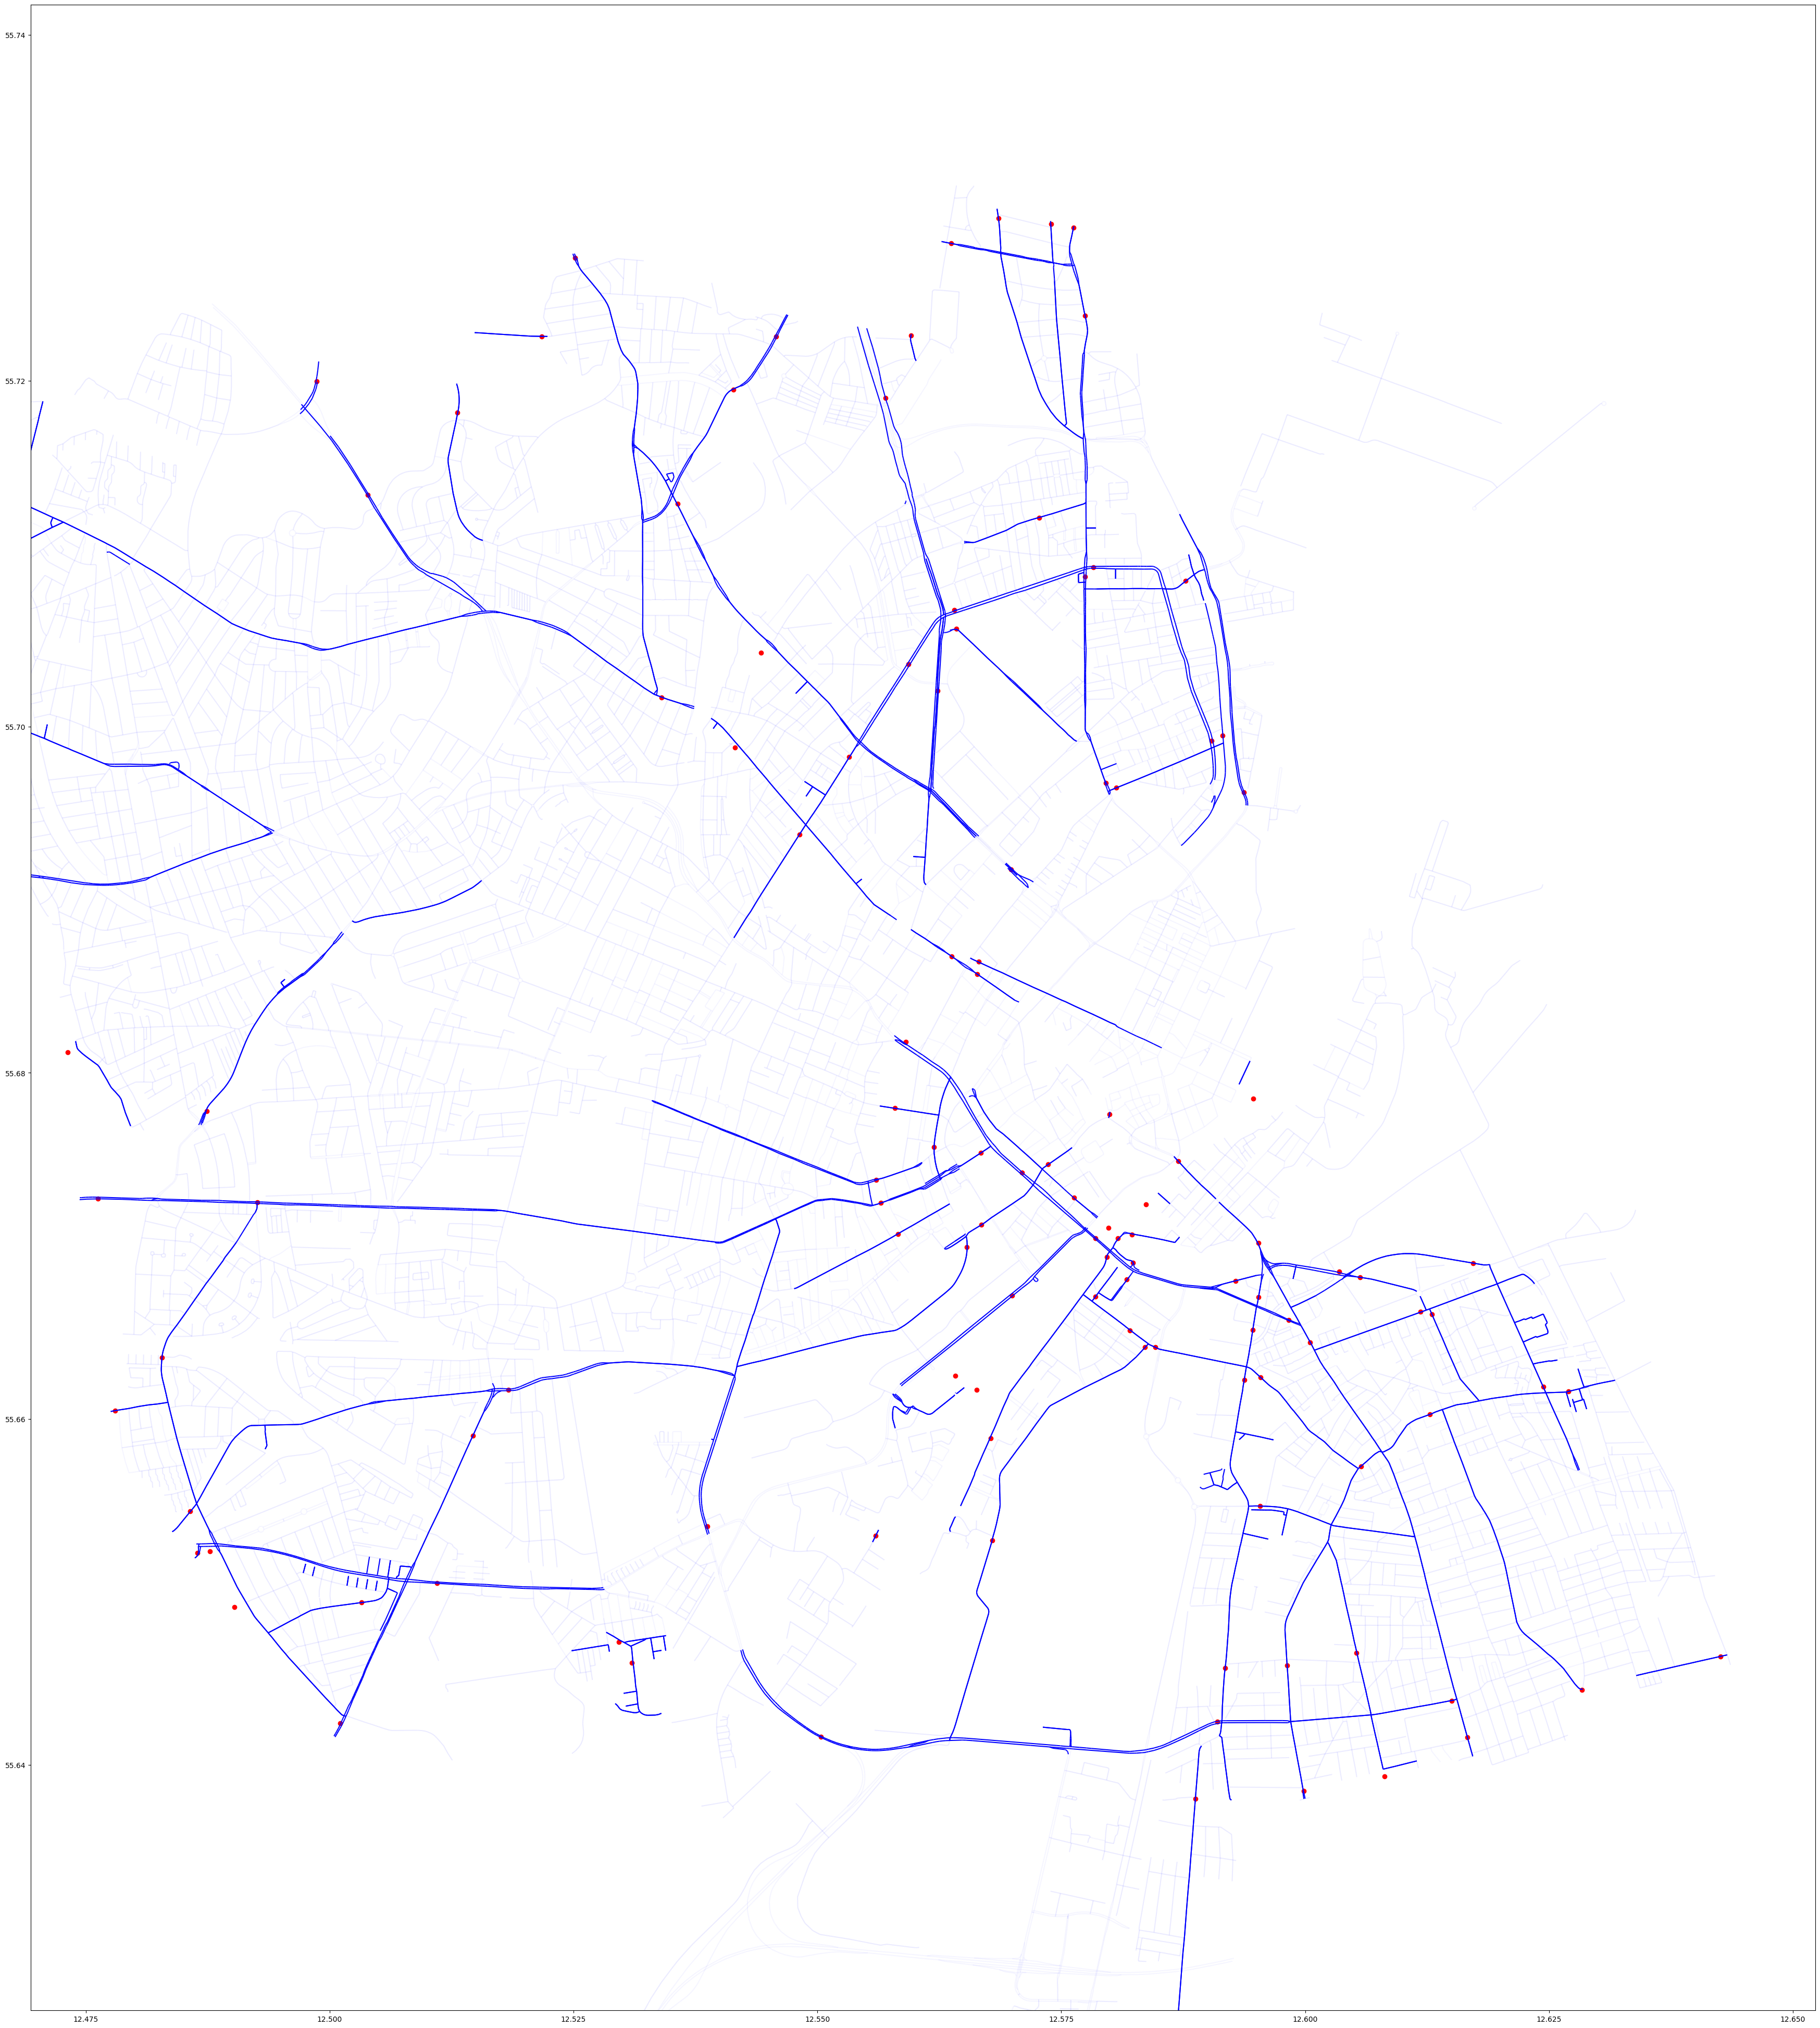

In [29]:
G_carall = ox.load_graphml('../../bikenwgrowth_external/data/copenhagen/bikedata/G_carall_graphml.graphml')
lanes = ox.graph_to_gdfs(G_carall, nodes=False)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ec = ['b' if (edges_dict[k]) ==meancount else 'blue' for k in edges_dict]
ac = [0.04 if (edges_dict[k]) == meancount else 1.0 for k in edges_dict]

ax = world[world.name == "Copenhagen municipality"].plot(color='black', edgecolor='black', figsize=(50,50),bgcolor = 'black')
bikelanes.plot(ax=ax, color='red')
lanes.plot(ax=ax, color=ec, alpha= ac)
#bikelanes2.plot(ax=ax, color='red', alpha = 0.3,linestyle=(0,(5,10)))



plt.axis([12.469380, 12.652281, 55.625802, 55.741728])


plt.show()

In [32]:
edges_dict

{(118725, 2512504197, 0): 7398.373983739837,
 (118725, 298795891, 0): 13650.0,
 (118730, 1051183834, 0): 7398.373983739837,
 (118731, 1051183809, 0): 4100.0,
 (118732, 6534097568, 0): 7398.373983739837,
 (118732, 283603631, 0): 7398.373983739837,
 (118733, 4924695578, 0): 7398.373983739837,
 (118735, 8977396171, 0): 7398.373983739837,
 (118735, 4393215585, 0): 4100.0,
 (118737, 2935851405, 0): 7398.373983739837,
 (118738, 1051990746, 0): 7398.373983739837,
 (118739, 588481105, 0): 7398.373983739837,
 (118747, 6651812229, 0): 22100.0,
 (118747, 1052455426, 0): 7398.373983739837,
 (118748, 1051183765, 0): 7398.373983739837,
 (118749, 1052455244, 0): 7398.373983739837,
 (118750, 1052455372, 0): 7398.373983739837,
 (118751, 118747, 0): 22100.0,
 (118751, 3574460115, 0): 7398.373983739837,
 (118751, 6651812218, 0): 7398.373983739837,
 (118752, 1052455274, 0): 7398.373983739837,
 (118753, 7640808912, 0): 7398.373983739837,
 (118754, 1052455228, 0): 7398.373983739837,
 (118755, 1052455297, 0)

In [35]:
ox.get_nearest_edges(G_carall,bikelanes.iloc[0].lat,bikelanes.iloc[0].long)

TypeError: 'numpy.float64' object is not iterable

In [51]:
a = nx.attr_matrix(G_carall,edge_attr='length')

/var/folders/r8/tq2ln28d2vg5b08rjdywrcvc0000gn/T/ipykernel_8937/1638163564.py:1: FutureWarning: attr_matrix will return an numpy.ndarray instead of a numpy.matrix in NetworkX 3.0.
  a = nx.attr_matrix(G_carall,edge_attr='length')


In [52]:
print(a)

(matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), [1671954438, 7412645901, 7412645903, 5693767697, 5693767698, 279969819, 475136029, 5382733854, 5382733855, 9658040358, 279969850, 323092577, 1681522790, 1681522791, 435683447, 1574174852, 3640000662, 3640000665, 3640000666, 5191762074, 5191762075, 5191762077, 3640000671, 5191762081, 9571008673, 9571008674, 9571008675, 276168893, 1656881361, 278528213, 278528214, 283115735, 475136224, 445513956, 278528232, 278528233, 278528236, 279970028, 278528256, 278528271, 9837347130, 9837347131, 2176844129, 2709913967, 2709913968, 2709913969, 2709913970, 1591476597, 2709913973, 278528398, 310378895, 310378896, 310378899, 310378900, 380633502, 359661992, 412352936, 412352937, 4723966378, 412352944, 412352945, 5709620152, 310378949, 310378950, 310378951, 

In [ ]:
#Normalise bikecounts a
x = count_df.drop(count_df.columns[[1,2,3,4,5,6]], axis=1) #returns a numpy array of only bikecounts
for i in range(len(x)):
    x.iloc[i].bicycle_count = 1.0/float(x.iloc[i]+1)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1, 1.0))
x_scaled = min_max_scaler.fit_transform(x)
bike_norm_df = pd.DataFrame(x_scaled)
bike_norm_df

count_df['bcount_attr']= bike_norm_df

count_df.insert(1, "bcount_attr", bike_norm_df)

count_df

In [ ]:
Audio(sound_file, autoplay=True)